In [2]:
import pandas as pd
import plotly.express as px
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from typing import List, Tuple
from xgboost import XGBRegressor 
import uuid
import datetime 
import time
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GridSearchCV, train_test_split
from utils.output_analysis import plot_decision_tree_importance, plot_player_value_trends, save_output_tables, create_shapley_values_plots
from utils.model import test_train_split, define_features, analysis_result
import optuna
from config import features, test_start, target



C:\Users\tomkn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
start = time.time()

In [4]:
pdf_mvp = pd.read_csv("data/intermediate/time_series_model_data_prep.csv") 

In [5]:
version  = "v0.0.4"

In [6]:

features = define_features(pdf_mvp, features)

pdf_train, pdf_test = test_train_split(pdf_mvp, test_start)

In [7]:
def objective(
    trial: optuna.Trial,
    X: pd.DataFrame,
    y: pd.Series,
    tscv: TimeSeriesSplit,
) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),  # Number of trees
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),  # Learning rate
        "max_depth": trial.suggest_int("max_depth", 1, 7),  # Tree depth
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Subsampling fraction
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),  # Min loss reduction for split
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),  # L1 regularization
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),  # L2 regularization
        "random_state": 42,
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "verbosity": 0,
    }

    rmse_scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, preds)
        rmse_scores.append(rmse)

    return sum(rmse_scores) / len(rmse_scores)  # Average RMSE across folds


In [8]:

from utils.model import prepare_future_year_data

In [9]:




def predict_future_values(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    prediction_years: List[int],
    features: List[str],
    n_trials: int = 20,
) -> Tuple[pd.DataFrame, XGBRegressor, pd.Series]:
    """
    Predicts future player values for specified years using XGBoost and Optuna hyperparameter tuning.

    Args:
        train_df: Training DataFrame with features and target.
        test_df: Initial test DataFrame to predict from (starting year).
        prediction_years: List of years to predict, starting with the base year.
        features: List of feature column names to use.
        n_trials: Number of Optuna trials for hyperparameter search.

    Returns:
        Tuple of:
            - DataFrame with predicted values for all prediction years concatenated.
            - Trained XGBRegressor using best Optuna params.
            - y_test from the base year (only valid for the first year).
    """

    X_train = train_df[features]
    y_train = train_df[target]

    tscv = TimeSeriesSplit(n_splits=3)

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train, tscv), n_trials=n_trials, show_progress_bar=False)

    print(f"Best trial params: {study.best_trial.params}")
    print(f"Best trial RMSE: {study.best_value:.4f}")

    # Train final model on all training data with best params
    best_params = study.best_trial.params
    # Add fixed params required by XGBRegressor
    best_params.update({
        "random_state": 42,
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "verbosity": 0,
    })

    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train)

    predictions = []
    current_df = test_df.copy()

    for i, year in enumerate(prediction_years):
        X_test = current_df[features]
        current_df["predicted_value"] = model.predict(X_test)
        current_df["year"] = year

        if i == 0:
            y_test = current_df[target]
            analysis_result(current_df, y_test, year, target)
            create_shapley_values_plots(model, X_train, features)
        else:
            current_df["age"] = current_df["age_last_year"] + 1

        # Reduce contract years left by 1, never below 0
        if "contract_years_left" in current_df.columns:
            current_df["contract_years_left"] = (current_df["contract_years_left"] - 1).clip(lower=0)

        current_df["age_last_year"] = current_df["age"]
        current_df["value_last_year"] = current_df["predicted_value"]

        predictions.append(current_df[["player_id", "year", "age", "predicted_value"]].copy())

        if i < len(prediction_years) - 1:
            current_df = prepare_future_year_data(current_df)

    all_predictions_df = pd.concat(predictions, ignore_index=True)
    return all_predictions_df, model, y_test


In [10]:
pdf_train

,player_id,name,year,date_of_birth,market_value_in_million_eur,age,position,sub_position,contract_years_left,value_last_year,...,subpos_Defensive Midfield,subpos_Goalkeeper,subpos_Left Midfield,subpos_Left Winger,subpos_Left-Back,subpos_Right Midfield,subpos_Right Winger,subpos_Right-Back,subpos_Second Striker,age_from_peak
0,132,Tomas Rosicky,2005,1980-10-04 00:00:00,11.0,24,Midfield,Attacking Midfield,0.0,13.00,...,False,False,False,False,False,False,False,False,False,1
1,132,Tomas Rosicky,2006,1980-10-04 00:00:00,11.0,25,Midfield,Attacking Midfield,0.0,11.00,...,False,False,False,False,False,False,False,False,False,0
2,132,Tomas Rosicky,2007,1980-10-04 00:00:00,14.4,26,Midfield,Attacking Midfield,0.0,11.00,...,False,False,False,False,False,False,False,False,False,1
3,132,Tomas Rosicky,2008,1980-10-04 00:00:00,17.5,27,Midfield,Attacking Midfield,0.0,14.40,...,False,False,False,False,False,False,False,False,False,4
4,132,Tomas Rosicky,2009,1980-10-04 00:00:00,15.5,28,Midfield,Attacking Midfield,0.0,17.50,...,False,False,False,False,False,False,False,False,False,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14137,842341,Maxime Estève,2022,2002-05-26 00:00:00,4.5,20,Defender,Centre-Back,0.0,0.80,...,False,False,False,False,False,False,False,False,False,25
14141,852024,Bénie Traoré,2022,2002-11-30 00:00:00,1.0,19,Attack,Centre-Forward,6.0,1.20,...,False,False,False,False,False,False,False,False,False,36
14145,855256,Alex Scott,2022,2003-08-21 00:00:00,0.8,18,Midfield,Central Midfield,6.0,0.05,...,False,False,False,False,False,False,False,False,False,49
14152,862297,Nasser Djiga,2022,2002-11-15 00:00:00,0.5,19,Defender,Centre-Back,6.0,0.50,...,False,False,False,False,False,False,False,False,False,36


[I 2025-07-31 16:44:15,669] A new study created in memory with name: no-name-a5355d39-d6d9-4474-b082-6d19b080de0f
[I 2025-07-31 16:44:15,998] Trial 0 finished with value: 4.804722060548634 and parameters: {'n_estimators': 69, 'learning_rate': 0.16897489289511838, 'max_depth': 5, 'subsample': 0.7494125249125357, 'colsample_bytree': 0.9822990222264116, 'gamma': 0.3641929733332949, 'reg_alpha': 0.13147977855695792, 'reg_lambda': 4.620237106053038}. Best is trial 0 with value: 4.804722060548634.
[I 2025-07-31 16:44:16,223] Trial 1 finished with value: 5.21964773267207 and parameters: {'n_estimators': 128, 'learning_rate': 0.22825059837301362, 'max_depth': 2, 'subsample': 0.58084404835995, 'colsample_bytree': 0.7683838908458354, 'gamma': 3.2902328102981313, 'reg_alpha': 0.45778389544797327, 'reg_lambda': 7.161070678603882}. Best is trial 0 with value: 4.804722060548634.
[I 2025-07-31 16:44:16,546] Trial 2 finished with value: 6.047105799299016 and parameters: {'n_estimators': 148, 'learning

Best trial params: {'n_estimators': 108, 'learning_rate': 0.23000811895922715, 'max_depth': 2, 'subsample': 0.7382883532154241, 'colsample_bytree': 0.9331868551521879, 'gamma': 2.63561893528035, 'reg_alpha': 0.32574071070090377, 'reg_lambda': 2.6653180890594315}
Best trial RMSE: 4.7299
2023 RMSE: 6.73
2023 R²: 0.821


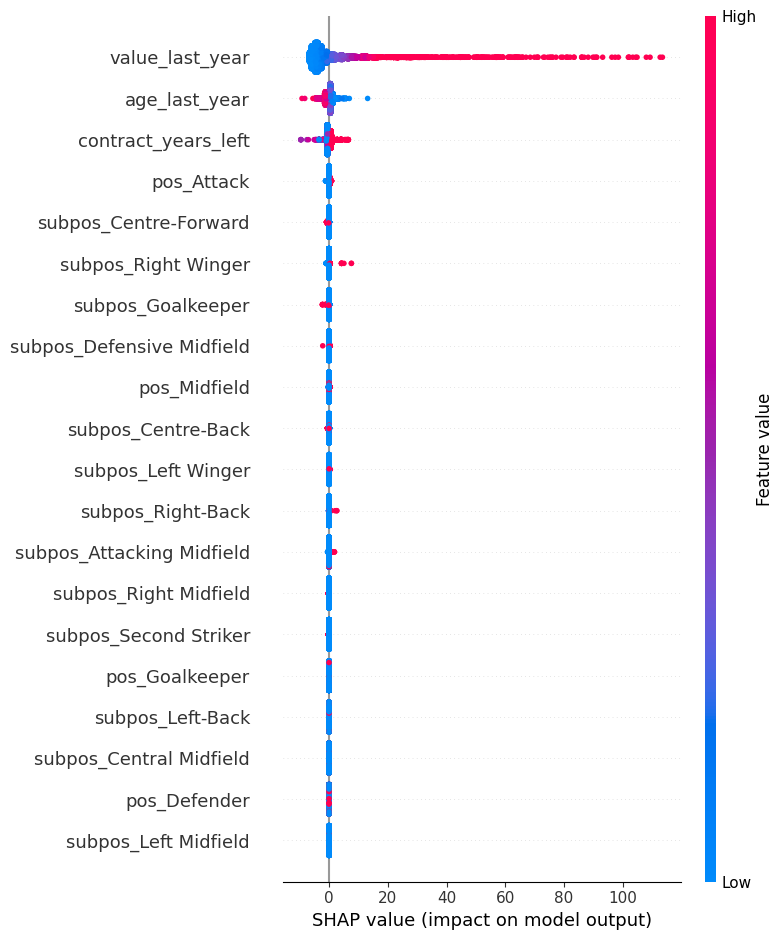

In [11]:
forecast_df, regressor, y_test = predict_future_values(    pdf_train, 
    pdf_test, [2023, 2024, 2025, 2026, 2027, 2028], features)

In [12]:
# Merge with actual market values for evaluation

merged = forecast_df.merge(pdf_test[["player_id", "name"]], on=["player_id"], how="left")
end = time.time()
diff = end - start

In [13]:
# plot_decision_tree_importance(regressor.best_estimator_, features)

In [14]:
players = [418560, 357662, 565822, 859951, 148455, 274839, 542580, 568177]
plot_player_value_trends(pdf_train, merged_df=merged, player_ids=players)


In [15]:
output_df = merged.query("year == 2023")
output_df["actual_value"] = y_test.values


C:\Users\tomkn\AppData\Local\Temp\ipykernel_15428\2121820575.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
output_df["model_output_id"] = uuid.uuid4()
output_df["model_run_date"] = datetime.datetime.now()
output_df["time_taken_seconds"] = diff
output_df["features_used"] = str(features)
output_df["model_type"] = "XG_Boost"
output_df["split_year"] = test_start
output_df["version"] = version

C:\Users\tomkn\AppData\Local\Temp\ipykernel_15428\1487859311.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tomkn\AppData\Local\Temp\ipykernel_15428\1487859311.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tomkn\AppData\Local\Temp\ipykernel_15428\1487859311.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [17]:
# save_output_tables(output_df)